In [1]:
# --- Block 1: Import required modules ---
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
# --- Block 2: Brain masking function ---
def brain_mask_2d(img):
    """
    Removes skull/background regions from a 2D MRI slice.
    Input: np.ndarray (grayscale)
    Output: np.ndarray (masked grayscale)
    """
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    # Step 1: Gaussian blur
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Step 2: Binary mask (Otsu)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step 3: Largest contour = brain
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return img  # fallback
    
    largest = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(img)
    cv2.drawContours(mask, [largest], -1, 255, -1)
    
    # Step 4: Apply mask
    masked = cv2.bitwise_and(img, img, mask=mask)
    return masked


In [3]:
# --- Block 3: Custom MRI Dataset ---
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_brain=True):
        """
        root_dir: path to dataset split (e.g., Data/Training)
        transform: torchvision transforms
        mask_brain: whether to perform skull stripping
        """
        self.root_dir = root_dir
        self.transform = transform
        self.mask_brain = mask_brain
        self.samples = []
        
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Gather all image paths
        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(cls_path, img_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Apply brain masking
        if self.mask_brain:
            img = brain_mask_2d(img)
        
        img = Image.fromarray(img)
        
        # Apply transforms (resize, normalize, etc.)
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        
        return img, label


In [4]:
# --- Block 4: Define transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [5]:
# --- Block 5: Create DataLoader ---
train_dir = "Data/Training"
train_dataset = MRIDataset(root_dir=train_dir, transform=transform, mask_brain=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

print(f"Total training samples: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")


Total training samples: 5712
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


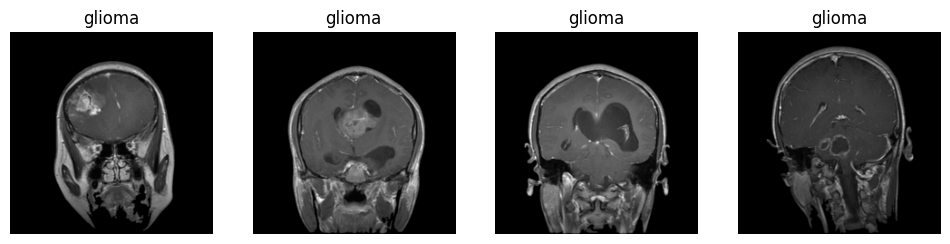

In [6]:
# --- Block 6: Visualize before vs after ---
def show_masking_preview(dataset, n=4):
    fig, axes = plt.subplots(1, n, figsize=(12, 4))
    for i in range(n):
        img, label = dataset[i]
        img = img.squeeze().numpy()
        cls = dataset.classes[label]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(cls)
        axes[i].axis('off')
    plt.show()

show_masking_preview(train_dataset, n=4)


In [7]:
# --- Block 7: Save masked dataset ---
output_dir = "Masked_Data"
os.makedirs(output_dir, exist_ok=True)

for cls in train_dataset.classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

for img_path, label in tqdm(train_dataset.samples):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    masked = brain_mask_2d(img)
    cls_name = train_dataset.classes[label]
    out_path = os.path.join(output_dir, cls_name, os.path.basename(img_path))
    cv2.imwrite(out_path, masked)


100%|██████████| 5712/5712 [00:20<00:00, 279.90it/s]


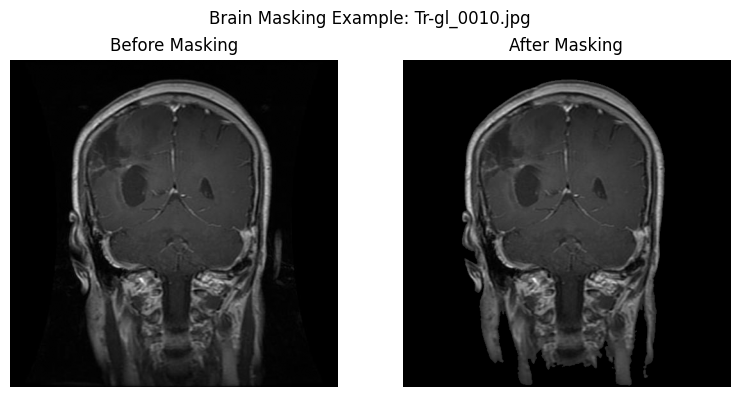

In [10]:
# --- Block: Visualize before and after brain masking ---
import cv2
import matplotlib.pyplot as plt

# Pick one sample image (change this path if you want)
sample_path = "Data/Training/glioma"  # change category if needed
sample_img_name = os.listdir(sample_path)[10]
sample_img_path = os.path.join(sample_path, sample_img_name)

# Load the original image (grayscale)
original = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)

# Apply brain masking
masked = brain_mask_2d(original)

# Plot both side by side
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(original, cmap='gray')
plt.title("Before Masking")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(masked, cmap='gray')
plt.title("After Masking")
plt.axis('off')

plt.suptitle(f"Brain Masking Example: {sample_img_name}", fontsize=12)
plt.tight_layout()
plt.show()


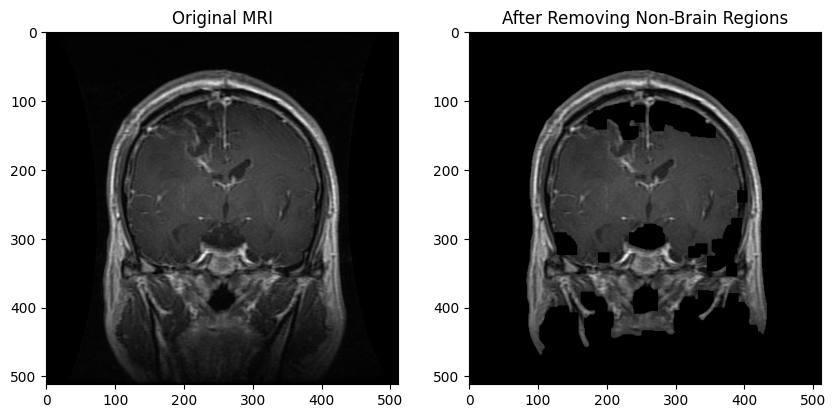

In [15]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load MRI image
img_path = "Data/Training/glioma/Tr-gl_0013.jpg"  # change as needed
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Convert to PyTorch tensor
img_tensor = torch.tensor(img, dtype=torch.float32) / 255.0

# Apply threshold to isolate brain
threshold = 0.2
mask = (img_tensor > threshold).float()

# Morphological cleaning (using OpenCV for convenience)
mask_np = mask.numpy().astype(np.uint8) * 255
mask_np = cv2.medianBlur(mask_np, 7)
mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))

# Convert back to tensor
mask = torch.tensor(mask_np / 255.0)

# Apply mask to image
cleaned_img = img_tensor * mask

# Show before vs after
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_tensor, cmap='gray')
plt.title("Original MRI")

plt.subplot(1, 2, 2)
plt.imshow(cleaned_img, cmap='gray')
plt.title("After Removing Non-Brain Regions")

plt.show()


In [14]:
print(img_path)
print(img is None)


Data/Training/glioma/TCGA_CS_4946_19960909_10.jpg
True


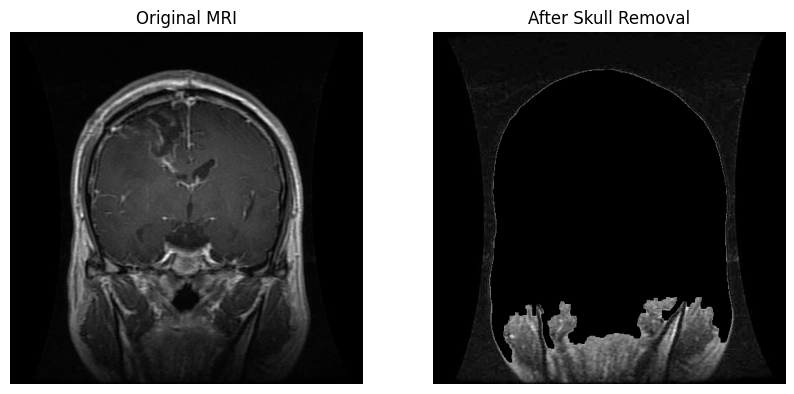

In [16]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Step 1: Load image ---
img_path = "Data/Training/glioma/Tr-gl_0013.jpg"  # replace with your path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found. Check your path!")

# --- Step 2: Normalize and smooth ---
img_blur = cv2.GaussianBlur(img, (5, 5), 0)

# --- Step 3: Apply Otsu thresholding ---
_, thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert it so brain is white, background/skull black
mask = cv2.bitwise_not(thresh)

# --- Step 4: Morphological operations to clean mask ---
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# --- Step 5: Keep only the largest connected component (the brain) ---
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # skip background
mask = np.uint8(labels == largest_label) * 255

# --- Step 6: Apply the mask to the original image ---
masked_img = cv2.bitwise_and(img, mask)

# --- Step 7: Convert to torch tensors if you want to use them in PyTorch ---
img_tensor = torch.tensor(img / 255.0, dtype=torch.float32)
mask_tensor = torch.tensor(mask / 255.0, dtype=torch.float32)
masked_tensor = img_tensor * mask_tensor

# --- Step 8: Display before and after ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original MRI")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("After Skull Removal")
plt.imshow(masked_img, cmap='gray')
plt.axis('off')

plt.show()


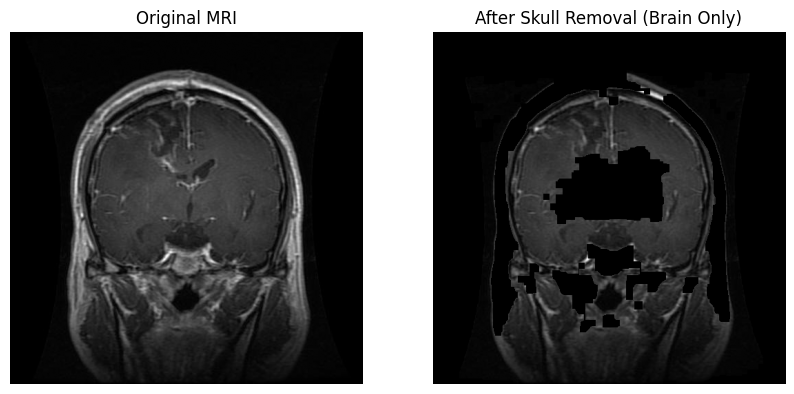

In [18]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Step 1: Load image ---
img_path = "Data/Training/glioma/Tr-gl_0013.jpg"  # change to your path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found. Check the path!")

# --- Step 2: Normalize & smooth ---
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img_blur = cv2.GaussianBlur(img_norm, (5, 5), 0)

# --- Step 3: Intensity-based thresholding ---
# Brain tissue is mid-intensity (not too bright or dark)
# Let's use percentile-based thresholds instead of Otsu
low_thr = np.percentile(img_blur, 40)   # lower bound of brain intensity
high_thr = np.percentile(img_blur, 80)  # upper bound of brain intensity
mask = cv2.inRange(img_blur, low_thr, high_thr)

# --- Step 4: Morphological refinement ---
kernel = np.ones((5, 5), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

# --- Step 5: Keep largest connected component (the brain) ---
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
brain_mask = np.uint8(labels == largest_label) * 255

# --- Step 6: Apply mask to image ---
masked_img = cv2.bitwise_and(img, brain_mask)

# --- Step 7: Convert to torch tensors (optional) ---
img_tensor = torch.tensor(img / 255.0, dtype=torch.float32)
mask_tensor = torch.tensor(brain_mask / 255.0, dtype=torch.float32)
masked_tensor = img_tensor * mask_tensor

# --- Step 8: Display results ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original MRI")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("After Skull Removal (Brain Only)")
plt.imshow(masked_img, cmap="gray")
plt.axis("off")

plt.show()


In [19]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Step 1: Load image ---
img_path = "Data/Training/glioma/Tr-gl_0013.jpg"  # change to your path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found. Check the path!")

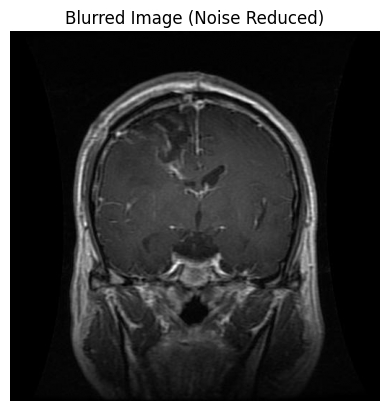

In [ ]:
blurred = cv2.GaussianBlur(img, (5, 5), 0)

# Show the blurred image
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image (Noise Reduced)')
plt.axis('off')
plt.show()

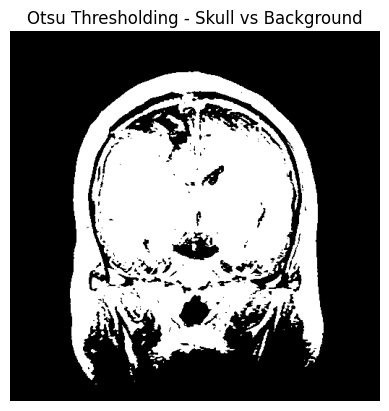

In [26]:
_, otsu_mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show the mask
plt.imshow(otsu_mask, cmap='gray')
plt.title('Otsu Thresholding - Skull vs Background')
plt.axis('off')
plt.show()

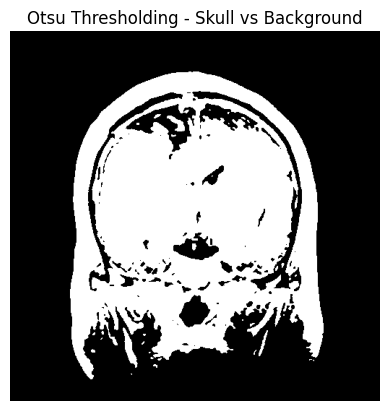

In [27]:
_, otsu_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show the mask
plt.imshow(otsu_mask, cmap='gray')
plt.title('Otsu Thresholding - Skull vs Background')
plt.axis('off')
plt.show()

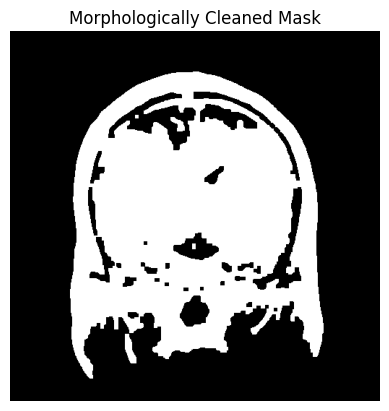

In [28]:
kernel = np.ones((5, 5), np.uint8)

# First, remove small white noise (opening = erosion followed by dilation)
opened = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel)

# Then, fill small holes (closing = dilation followed by erosion)
clean_mask = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

# Show the cleaned mask
plt.imshow(clean_mask, cmap='gray')
plt.title('Morphologically Cleaned Mask')
plt.axis('off')
plt.show()

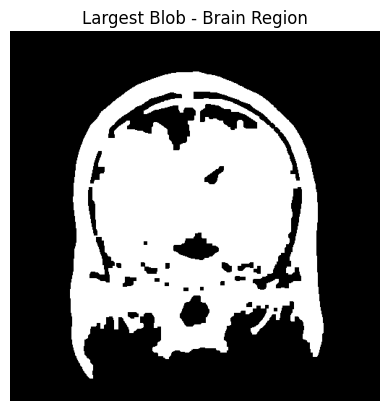

In [29]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean_mask, connectivity=8)

# Ignore the background (label 0), find the largest component
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

# Create a mask for only the largest blob
brain_mask = np.zeros_like(clean_mask)
brain_mask[labels == largest_label] = 255

# Show the largest component (brain)
plt.imshow(brain_mask, cmap='gray')
plt.title('Largest Blob - Brain Region')
plt.axis('off')
plt.show()

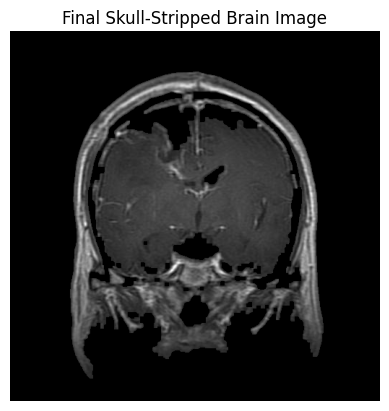

In [31]:
brain_only = cv2.bitwise_and(img, img, mask=brain_mask)

# Show the final skull-stripped image
plt.imshow(brain_only, cmap='gray')
plt.title('Final Skull-Stripped Brain Image')
plt.axis('off')
plt.show()

Image shape: (512, 512)


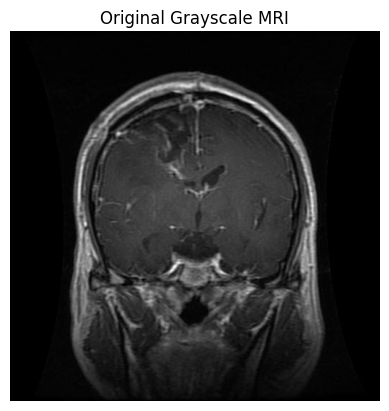

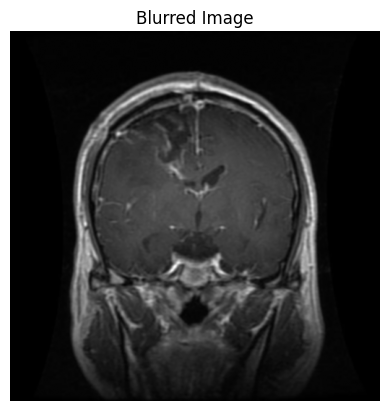

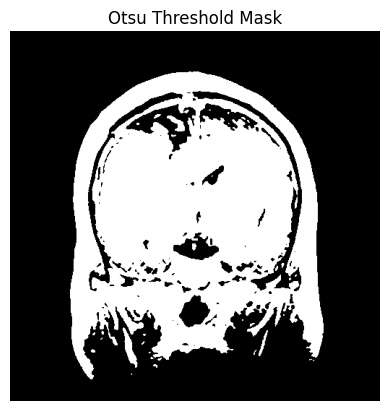

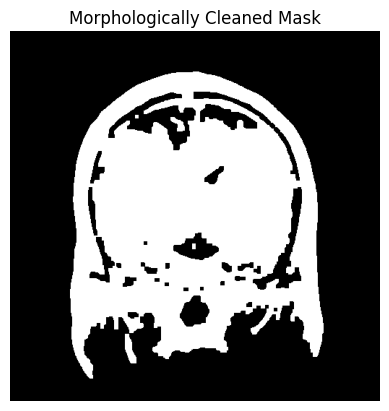

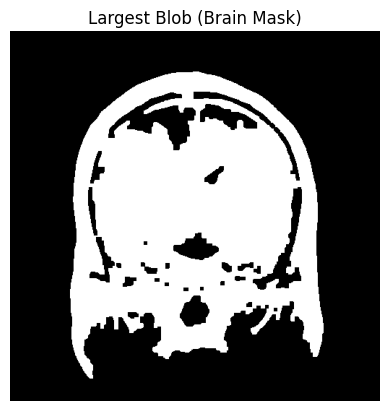

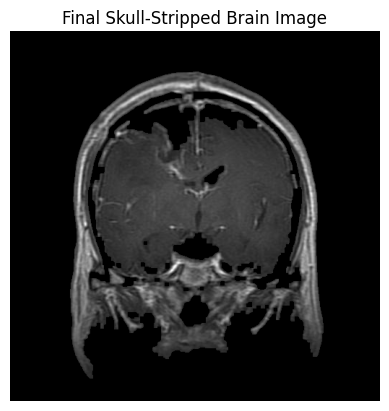

In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# ----------------------------
# 1. Load the image
# ----------------------------
img_path = "Data/Training/glioma/Tr-gl_0013.jpg"
gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print("Image shape:", gray.shape)

plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale MRI")
plt.axis('off')
plt.show()

# ----------------------------
# 2. Apply Gaussian Blur
# ----------------------------
blurred = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(blurred, cmap='gray')
plt.title("Blurred Image")
plt.axis('off')
plt.show()

# ----------------------------
# 3. Otsu's Thresholding
# ----------------------------
_, otsu_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(otsu_mask, cmap='gray')
plt.title("Otsu Threshold Mask")
plt.axis('off')
plt.show()

# ----------------------------
# 4. Morphological Cleanup
# ----------------------------
kernel = np.ones((5,5), np.uint8)
opened = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel)
clean_mask = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

plt.imshow(clean_mask, cmap='gray')
plt.title("Morphologically Cleaned Mask")
plt.axis('off')
plt.show()

# ----------------------------
# 5. Keep Largest Blob (Brain)
# ----------------------------
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(clean_mask, connectivity=8)
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

brain_mask = np.zeros_like(clean_mask)
brain_mask[labels == largest_label] = 255

plt.imshow(brain_mask, cmap='gray')
plt.title("Largest Blob (Brain Mask)")
plt.axis('off')
plt.show()

# ----------------------------
# 6. Apply Mask to remove skull
# ----------------------------
brain_only = cv2.bitwise_and(gray, gray, mask=brain_mask)

plt.imshow(brain_only, cmap='gray')
plt.title("Final Skull-Stripped Brain Image")
plt.axis('off')
plt.show()


In [35]:
import matplotlib.pyplot as plt

from ipywidgets import interact
import numpy as np
import SimpleITK as sitk
import cv2

def explore_3D_array(arr: np.ndarray, cmap: str = 'gray'):
  """
  Given a 3D array with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D array. 
  The purpose of this function to visual inspect the 2D arrays in the image. 

  Args:
    arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """

  def fn(SLICE):
    plt.figure(figsize=(7,7))
    plt.imshow(arr[SLICE, :, :], cmap=cmap)

  interact(fn, SLICE=(0, arr.shape[0]-1))


def explore_3D_array_comparison(arr_before: np.ndarray, arr_after: np.ndarray, cmap: str = 'gray'):
  """
  Given two 3D arrays with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D arrays.
  The purpose of this function to visual compare the 2D arrays after some transformation. 

  Args:
    arr_before : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, before any transform
    arr_after : 3D array with shape (Z,X,Y) that represents the volume of a MRI image, after some transform    
    cmap : Which color map use to plot the slices in matplotlib.pyplot
  """

  assert arr_after.shape == arr_before.shape

  def fn(SLICE):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10,10))

    ax1.set_title('Before', fontsize=15)
    ax1.imshow(arr_before[SLICE, :, :], cmap=cmap)

    ax2.set_title('After', fontsize=15)
    ax2.imshow(arr_after[SLICE, :, :], cmap=cmap)

    plt.tight_layout()

  interact(fn, SLICE=(0, arr_before.shape[0]-1))


def show_sitk_img_info(img: sitk.Image):
  """
  Given a sitk.Image instance prints the information about the MRI image contained.

  Args:
    img : instance of the sitk.Image to check out
  """
  pixel_type = img.GetPixelIDTypeAsString()
  origin = img.GetOrigin()
  dimensions = img.GetSize()
  spacing = img.GetSpacing()
  direction = img.GetDirection()

  info = {'Pixel Type' : pixel_type, 'Dimensions': dimensions, 'Spacing': spacing, 'Origin': origin,  'Direction' : direction}
  for k,v in info.items():
    print(f' {k} : {v}')


def add_suffix_to_filename(filename: str, suffix:str) -> str:
  """
  Takes a NIfTI filename and appends a suffix.

  Args:
      filename : NIfTI filename
      suffix : suffix to append

  Returns:
      str : filename after append the suffix
  """
  if filename.endswith('.nii'):
      result = filename.replace('.nii', f'_{suffix}.nii')
      return result
  elif filename.endswith('.nii.gz'):
      result = filename.replace('.nii.gz', f'_{suffix}.nii.gz')
      return result
  else:
      raise RuntimeError('filename with unknown extension')


def rescale_linear(array: np.ndarray, new_min: int, new_max: int):
  """Rescale an array linearly."""
  minimum, maximum = np.min(array), np.max(array)
  m = (new_max - new_min) / (maximum - minimum)
  b = new_min - m * minimum
  return m * array + b


def explore_3D_array_with_mask_contour(arr: np.ndarray, mask: np.ndarray, thickness: int = 1):
  """
  Given a 3D array with shape (Z,X,Y) This function will create an interactive
  widget to check out all the 2D arrays with shape (X,Y) inside the 3D array. The binary
  mask provided will be used to overlay contours of the region of interest over the 
  array. The purpose of this function is to visual inspect the region delimited by the mask.

  Args:
    arr : 3D array with shape (Z,X,Y) that represents the volume of a MRI image
    mask : binary mask to obtain the region of interest
  """
  assert arr.shape == mask.shape

  _arr = rescale_linear(arr,0,1)
  _mask = rescale_linear(mask,0,1)
  _mask = _mask.astype(np.uint8)

  def fn(SLICE):
    arr_rgb = cv2.cvtColor(_arr[SLICE, :, :], cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours(_mask[SLICE, :, :], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    arr_with_contours = cv2.drawContours(arr_rgb, contours, -1, (0,1,0), thickness)

    plt.figure(figsize=(7,7))
    plt.imshow(arr_with_contours)

  interact(fn, SLICE=(0, arr.shape[0]-1))

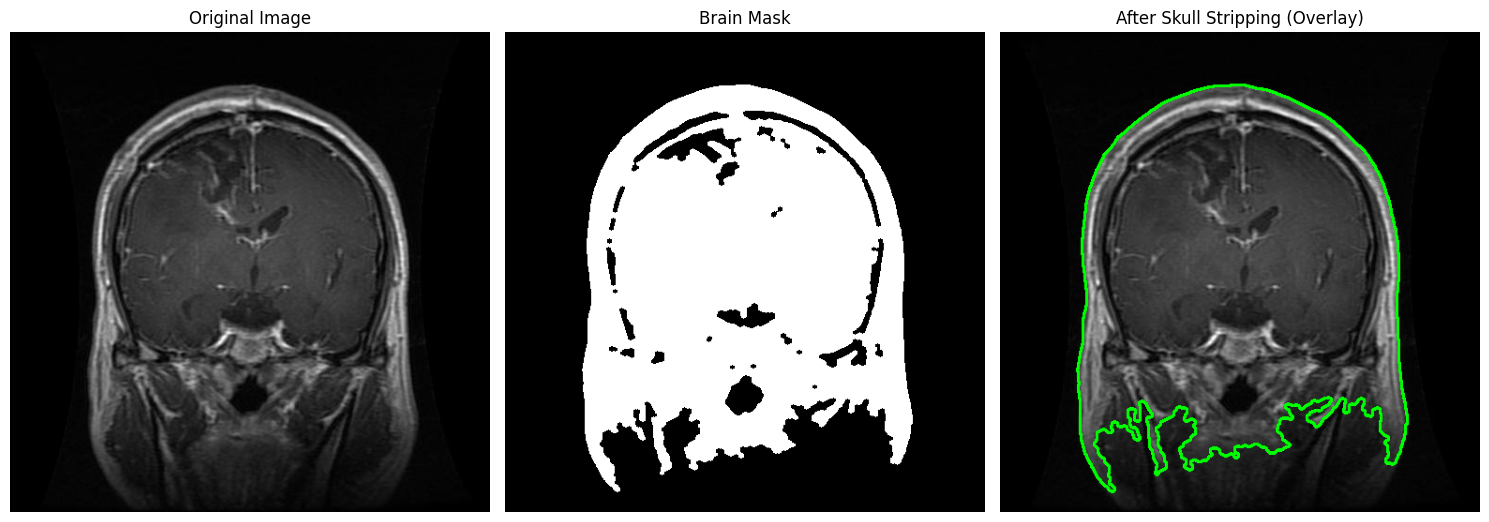

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, opening, disk
from skimage.measure import label

def skull_strip_2d(image_path, denoise_sigma=3, otsu_relax=-5, min_area=500, closing_radius=5):
    """
    Simulates skull-stripping for a 2D brain MRI image (JPG/PNG).

    Args:
        image_path (str): Path to the MRI brain image (e.g. .jpg)
        denoise_sigma (int): Gaussian blur kernel size (odd number)
        otsu_relax (float): Value to subtract from Otsu threshold (negative → looser)
        min_area (int): Minimum brain region area to keep
        closing_radius (int): Morphological closing kernel radius

    Returns:
        original (ndarray), mask (ndarray), stripped (ndarray)
    """

    # Load grayscale image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not open {image_path}")
    original = img.copy()

    # Step 1 — Denoise with Gaussian blur
    img_blur = cv2.GaussianBlur(img, (denoise_sigma, denoise_sigma), 0)

    # Step 2 — Compute Otsu threshold and relax slightly
    t = threshold_otsu(img_blur)
    t = t + otsu_relax
    _, mask = cv2.threshold(img_blur, t, 255, cv2.THRESH_BINARY)

    # Step 3 — Morphological cleaning (closing → opening)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (closing_radius, closing_radius))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Step 4 — Keep largest connected component (the brain)
    labels = label(mask > 0)
    if labels.max() > 0:
        counts = np.bincount(labels.ravel())
        counts[0] = 0
        largest_label = np.argmax(counts)
        mask = (labels == largest_label).astype(np.uint8) * 255

    # Step 5 — Apply mask (skull-stripped image)
    stripped = cv2.bitwise_and(original, original, mask=mask)

    # Step 6 — Visualize before & after
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Brain Mask')
    axes[1].axis('off')

    # Overlay contour on original
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    overlay = cv2.drawContours(overlay, contours, -1, (0,255,0), 2)

    axes[2].imshow(overlay)
    axes[2].set_title('After Skull Stripping (Overlay)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return original, mask, stripped


# --------------------------
# Example usage
# --------------------------
if __name__ == "__main__":
    image_path = "Data/Training/glioma/Tr-gl_0013.jpg"  # 👈 replace with your MRI JPG image
    skull_strip_2d(image_path)


In [38]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.filters import threshold_otsu
from skimage.measure import label

def skull_strip_2d(image_path, denoise_sigma=3, otsu_relax=-5, closing_radius=5):
    """
    Skull stripping for 2D MRI image.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not open {image_path}")

    original = img.copy()
    img_blur = cv2.GaussianBlur(img, (denoise_sigma, denoise_sigma), 0)

    # Otsu thresholding
    t = threshold_otsu(img_blur) + otsu_relax
    _, mask = cv2.threshold(img_blur, t, 255, cv2.THRESH_BINARY)

    # Morphological cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (closing_radius, closing_radius))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Keep largest connected component (brain)
    labels = label(mask > 0)
    if labels.max() > 0:
        counts = np.bincount(labels.ravel())
        counts[0] = 0
        largest_label = np.argmax(counts)
        mask = (labels == largest_label).astype(np.uint8) * 255

    stripped = cv2.bitwise_and(original, original, mask=mask)
    return stripped


def process_dataset(base_dir="Data", output_base="Data/Stripped", **kwargs):
    """
    Apply skull stripping to all images under Training, Testing, and Augmented.
    Saves to Data/Stripped with the same folder structure.
    """
    subsets = ["Training", "Testing", "Augmented"]
    tumor_types = ["meningioma", "glioma", "notumor", "pituitary"]

    for subset in subsets:
        for tumor in tumor_types:
            input_dir = os.path.join(base_dir, subset, tumor)
            output_dir = os.path.join(output_base, subset, tumor)
            os.makedirs(output_dir, exist_ok=True)

            image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            print(f"\n📁 Processing {subset}/{tumor} — {len(image_files)} images")

            for file_name in tqdm(image_files, desc=f"{subset}/{tumor}"):
                in_path = os.path.join(input_dir, file_name)
                out_path = os.path.join(output_dir, file_name)

                try:
                    stripped = skull_strip_2d(in_path, **kwargs)
                    cv2.imwrite(out_path, stripped)
                except Exception as e:
                    print(f"❌ Error processing {file_name}: {e}")

    print("\n✅ All done! Stripped dataset saved under:", output_base)


# --------------------------
# Example run
# --------------------------
if __name__ == "__main__":
    process_dataset(
        base_dir="Data",
        output_base="Data/Stripped",
        denoise_sigma=3,
        otsu_relax=-5,
        closing_radius=5
    )



📁 Processing Training/meningioma — 1339 images


Training/meningioma: 100%|██████████| 1339/1339 [00:20<00:00, 64.32it/s]



📁 Processing Training/glioma — 1321 images


Training/glioma: 100%|██████████| 1321/1321 [00:20<00:00, 63.86it/s]



📁 Processing Training/notumor — 1595 images


Training/notumor: 100%|██████████| 1595/1595 [00:24<00:00, 65.10it/s]



📁 Processing Training/pituitary — 1457 images


Training/pituitary: 100%|██████████| 1457/1457 [00:23<00:00, 61.34it/s]



📁 Processing Testing/meningioma — 306 images


Testing/meningioma: 100%|██████████| 306/306 [00:04<00:00, 68.42it/s]



📁 Processing Testing/glioma — 300 images


Testing/glioma: 100%|██████████| 300/300 [00:04<00:00, 63.99it/s]



📁 Processing Testing/notumor — 405 images


Testing/notumor: 100%|██████████| 405/405 [00:05<00:00, 80.38it/s]



📁 Processing Testing/pituitary — 300 images


Testing/pituitary: 100%|██████████| 300/300 [00:04<00:00, 61.10it/s]



📁 Processing Augmented/meningioma — 1339 images


Augmented/meningioma: 100%|██████████| 1339/1339 [00:14<00:00, 90.57it/s]



📁 Processing Augmented/glioma — 1321 images


Augmented/glioma: 100%|██████████| 1321/1321 [00:14<00:00, 88.87it/s]



📁 Processing Augmented/notumor — 1595 images


Augmented/notumor: 100%|██████████| 1595/1595 [00:18<00:00, 86.90it/s]



📁 Processing Augmented/pituitary — 1457 images


Augmented/pituitary: 100%|██████████| 1457/1457 [00:16<00:00, 88.14it/s]


✅ All done! Stripped dataset saved under: Data/Stripped
